In [1]:
import os 
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
# Avoiding OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

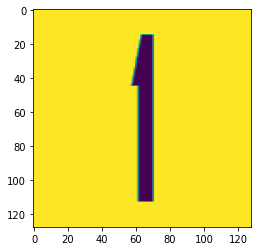

In [4]:
# Loading Data
data_dir = 'Data'
img = cv2.imread(os.path.join(data_dir,'1','img002-00001.png'))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
plt.show()

In [6]:
# Creating Dataset
data = tf.keras.utils.image_dataset_from_directory(data_dir,color_mode='grayscale',image_size=(28,28),label_mode='categorical')

Found 10160 files belonging to 10 classes.


In [7]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch[0][0].shape

(28, 28, 1)

In [8]:
batch[1]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 

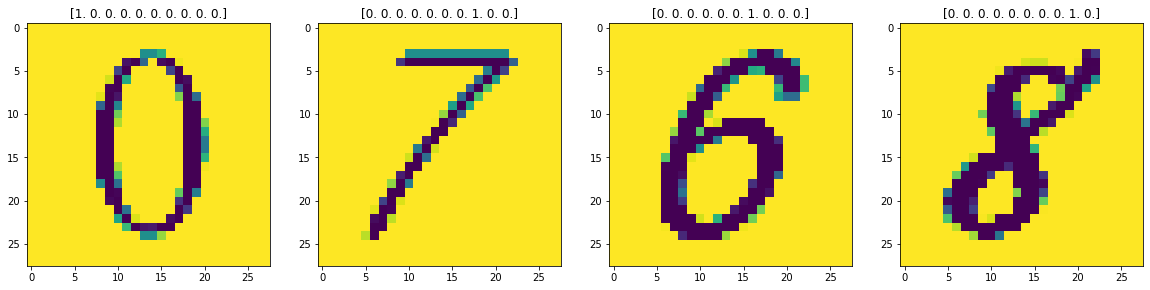

In [10]:
fig,ax = plt.subplots(ncols=4,figsize= (20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [11]:
# Normalizing data
data = data.map(lambda x,y:(x/255,y))

In [19]:
train_size = int(len(data)*0.7)
val_size  =int(len(data)*0.2)+1
test_size = int(len(data)*0.1)+1
train = data.take(train_size)
val = data.skip(train_size).take(val_size)


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Dropout

In [20]:
model = Sequential(
[
    # first set of CONV => RELU => Pool layers
    Conv2D(32,(5,5),padding = 'same',input_shape = (28,28,1),activation='relu'),
    MaxPooling2D(pool_size = (2,2)),

    # second set of CONV => RELU => POOL layers
    Conv2D(32,(3,3),padding = 'same',activation='relu'),
    MaxPooling2D(pool_size = (2,2)),

    # first set of FC => RELU layers
    Flatten(),
    Dense(64,activation='relu'),
    Dropout(0.5),

    # second set of FC => RELU layers
    Dense(64,activation='relu'),
    Dropout(0.5),

    # softmax classifier
    Dense(10,activation='softmax')
])
        
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_3 (Dense)             (None, 64)               

In [22]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
222/222 [==============================] - 15s 56ms/step - loss: 1.6212 - accuracy: 0.4137 - val_loss: 0.2717 - val_accuracy: 0.9473
Epoch 2/20
222/222 [==============================] - 12s 53ms/step - loss: 0.6068 - accuracy: 0.7952 - val_loss: 0.1196 - val_accuracy: 0.9614
Epoch 3/20
222/222 [==============================] - 12s 53ms/step - loss: 0.4092 - accuracy: 0.8592 - val_loss: 0.0868 - val_accuracy: 0.9775
Epoch 4/20
222/222 [==============================] - 12s 55ms/step - loss: 0.3213 - accuracy: 0.8908 - val_loss: 0.0644 - val_accuracy: 0.9834
Epoch 5/20
222/222 [==============================] - 12s 55ms/step - loss: 0.2657 - accuracy: 0.9079 - val_loss: 0.0542 - val_accuracy: 0.9878
Epoch 6/20
222/222 [==============================] - 15s 67ms/step - loss: 0.2352 - accuracy: 0.9172 - val_loss: 0.0450 - val_accuracy: 0.9873
Epoch 7/20
222/222 [==============================] - 13s 59ms/step - loss: 0.2100 - accuracy: 0.9291 - val_loss: 0.0539 - val_accuracy:

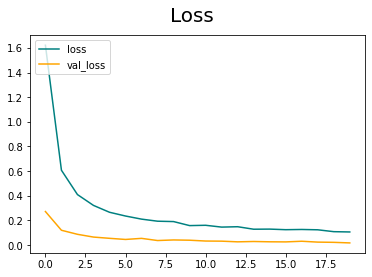

In [23]:
fig = plt.figure()
plt.plot(hist.history['loss'],color= 'teal',label = 'loss')
plt.plot(hist.history['val_loss'],color = 'orange',label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

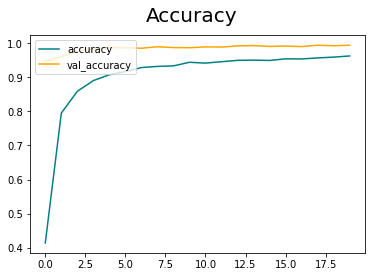

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color = 'teal',label = 'accuracy')
plt.plot(hist.history['val_accuracy'],color = 'orange',label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()